In [10]:
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd

from IPython.display import display, Image
from sklearn.metrics import roc_auc_score, roc_curve

from utils import get_class, load_data_sources, reset_seeds, get_positive_samples
from constants import protein_list, protein_names, experiment_set

style.use('seaborn-poster')

#Set random seeds for reproducibility.
reset_seeds()

In [ ]:
receptive_field = 0
receptive_field_previous = 1
filters = [6,20,4,40,4,30,3]
layers = ['conv1','pool1','conv2','pool2','conv3','pool3','conv4']

for i, filter_size in enumerate(filters):
    receptive_field = receptive_field_previous + filter_size - 1
    print('ERF of layer {} is {}'.format(layers[i], receptive_field))
    receptive_field_previous = receptive_field

In [9]:

from IPython.display import Latex

def makeplot(figname, figlabel, figcaption):
    strLatex=r"""\subsection{%s}
    \begin{figure}[h!]
        \begin{center}
            \includegraphics[width=\textwidth]{/%s}
            \caption{%s}
            \label{sf:%s}
        \end{center}
    \end{figure}
    \clearpage"""%(figlabel.split(" ")[1], figname, figcaption, figlabel.replace(" ", "_")) 
    return display(Latex(strLatex))

for protein, name in zip(protein_list, protein_names):
    fig_text = [
        f"Aggregated plots for {name.split(' ')[1]}. (a) Area under ROC curve analysis of iDeep, iONMF and mcBind. (b) Calibration curves for iDeep and mcBind. For each of the "
        "two models the distribution of predicted values is shown below. (c) Sequence logo based on most salient regions. (d) Sequence motifs based on filter activation. Filters are ordered "
        "by the impact on AUC when this filter is omitted. The number of times each filter was activated is written in parentheses. (e) Visualisation of filter weights. (f) Artificial sequence "
        "that achieves the maximum activation."
    ]
    makeplot(f"{protein}.png", name, fig_text[0])


<IPython.core.display.Latex object>

In [7]:
%run aggregate

In [ ]:
%run shallow_model.py

In [8]:
shallow_results = pd.read_csv("shallow_model/scores.tsv", sep="\t", index_col=0)
shallow_results.mean(axis=1).to_list()

[0.9414360833333334]

In [43]:
with open("results/scores_dict.pkl" , "rb") as pkl:
    scores_dict = pickle.load(pkl)

def latex_highlight(x):
    is_max = x == x.max()
    return [f'\\textbf{{{np.round(val, 2)}}}' if v else np.round(val, 2) for val, v in zip(x, is_max)]
def highlight_max(s):
    """Marks the series in bold."""
    is_max = s == s.max()
    return ['font-weight:bold' if v else '' for v in is_max]

ideep = [0.93668944, ]#0.76282461, 0.94159092, 0.94483924, 0.76107508, 0.95504916,
        #  0.97001479, 0.96485094, 0.76609511, 0.9469512,  0.9469512,  0.9525081,
        #  0.94539888, 0.98648477, 0.95614971, 0.94825049, 0.96873706, 0.84875831,
        #  0.82395875, 0.82983874, 0.97112416, 0.88624311, 0.98298004, 0.96877799,
        #  0.92754448, 0.97679184, 0.91218175, 0.94829456, 0.9227082,  0.95288192,
        #  0.94209036]

new = [v for v in scores_dict.values()]
shallow = shallow_results.mean(axis=1).to_list()

table_data = {'mcBind': new, 'iDeep': ideep, 'Shallow mcBind': shallow}

table = pd.DataFrame(table_data, index=protein_list)

d1 = np.subtract(new, ideep)
d2 = np.subtract(new, shallow)

n1 = sum(1 for number in d1 if number > 0)
n2 = sum(1 for number in d2 if number > 0)

print("Mean difference with iDeep is %s " % (np.mean(d1)))
print("Number of proteins for which our model is better: %s " % (n1))
print("Mean difference with Shallow mcbind is %s " % (np.mean(d2)))
print("Number of proteins for which our model is better: %s " % (n2))


with pd.option_context('display.precision', 3):
    html = (table.style.apply(highlight_max, axis=1))
latex_table = table.apply(latex_highlight, axis=1, result_type='expand')

html



Mean difference with iDeep is 0.006286143333333327 
Number of proteins for which our model is better: 1 
Mean difference with Shallow mcbind is 0.001539499999999916 
Number of proteins for which our model is better: 1 


,mcBind,iDeep,Shallow mcBind
1_PARCLIP_AGO1234_hg19,0.943,0.937,0.941


In [27]:
print(latex_table.to_latex(escape=False))

\begin{tabular}{lrrl}
\toprule
{} &     0 &     1 &              2 \\
\midrule
1_PARCLIP_AGO1234_hg19 &  0.94 &  0.94 &  \textbf{0.94} \\
\bottomrule
\end{tabular}



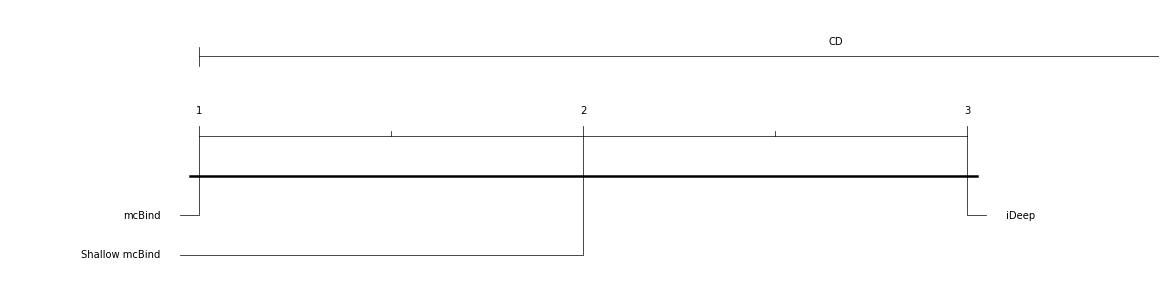

<Figure size 1440x576 with 0 Axes>

In [44]:
import Orange

ranks = table.rank(axis=1, method="min", ascending=False)
avranks = ranks.mean()
names = table.columns.to_list()
cd = Orange.evaluation.compute_CD(avranks, 1)
Orange.evaluation.graph_ranks(avranks, names, cd=cd, textspace=1)

fig = plt.gcf()
fig.set_size_inches(16, 4)

plt.show()
plt.savefig("results/critical_difference_shalow.png")